<h1 align="center"> --- Loan Default Classifier with Python --- </h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [73]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [74]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-01 14:18:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.09s   

2020-04-01 14:18:41 (263 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [75]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [76]:
df.shape

(346, 10)

### Convert to date time object 

In [77]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [78]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [79]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



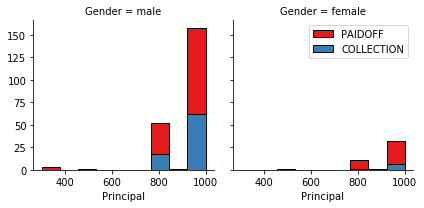

In [80]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

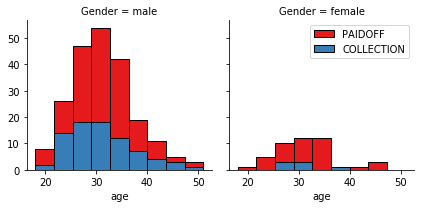

In [81]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

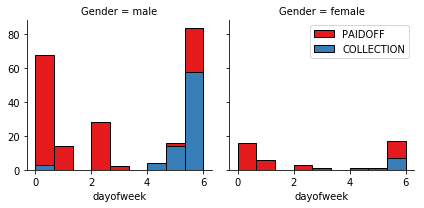

In [82]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [83]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [84]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [85]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [86]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [87]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [88]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [89]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [90]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [91]:
pd.DataFrame(y)[0].value_counts()

PAIDOFF       260
COLLECTION     86
Name: 0, dtype: int64

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [92]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Best accuracy: 0.7428571428571429 || K= 9


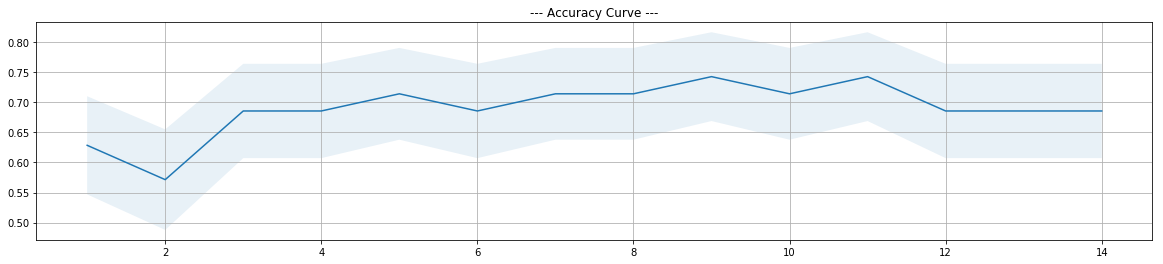

In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score,jaccard_similarity_score

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.1, random_state = 96)
K=15
acc = np.zeros((K-1))
std = np.zeros((K-1))
for k in range(1, K):
    kmeans = KNeighborsClassifier(n_neighbors=k).fit(xTrain,yTrain)
    yPred = kmeans.predict(xTest)    
    acc[k-1]=accuracy_score(yTest,yPred)
    std[k-1]=np.std(yPred==yTest)/np.sqrt(yPred.shape[0])


fig = plt.figure(figsize=(20, 4))
plt.fill_between(range(1,K),acc - 1 * std,acc + 1 * std, alpha=0.10)
plt.plot(range(1,K), acc)
plt.grid(True)
plt.title('--- Accuracy Curve ---')
K=acc.argmax()+1
print("Best accuracy:",acc.max(),"|| K=",K)

<h3>Train KNN with optimal K=9</h3>

In [119]:
knn = KNeighborsClassifier(n_neighbors = K).fit(xTrain,yTrain)
yPred = knn.predict(xTest)
print("Training Accuracy: ", accuracy_score(yTrain, knn.predict(xTrain)))
print("Test Accuracy: ", accuracy_score(yTest, yPred))
print ("\n Classification:",classification_report(yTest, yPred))
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))

Training Accuracy:  0.7909967845659164
Test Accuracy:  0.7428571428571429

 Classification:               precision    recall  f1-score   support

  COLLECTION       0.50      0.33      0.40         9
     PAIDOFF       0.79      0.88      0.84        26

   micro avg       0.74      0.74      0.74        35
   macro avg       0.65      0.61      0.62        35
weighted avg       0.72      0.74      0.72        35


 F1 Score 0.7241558441558441

 Jaccard_similarity_score: 0.7428571428571429


# Decision Tree

Best accuracy: 0.7428571428571429 || Max Depth= 1


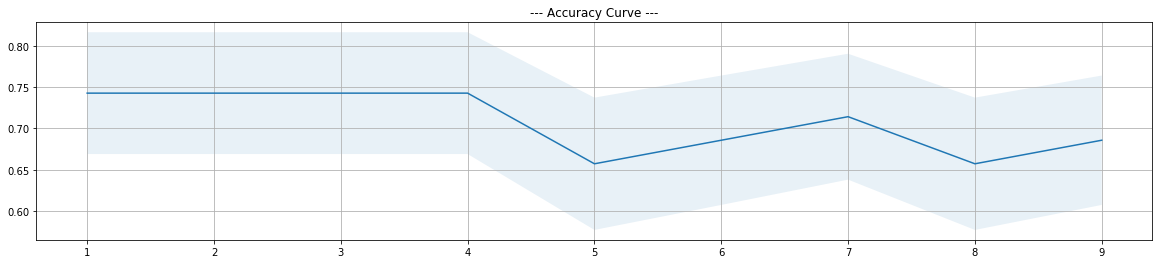

In [125]:
from sklearn.tree import DecisionTreeClassifier
D = 10
acc = np.zeros((D-1))
std = np.zeros((D-1))

for d in range(1,D):
    
    dtc = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(xTrain,yTrain)
    yPred=dtc.predict(xTest)
    acc[d-1] = metrics.accuracy_score(yTest, yPred)    
    std[d-1] = np.std(yPred==yTest)/np.sqrt(yPred.shape[0])

fig = plt.figure(figsize=(20, 4))
plt.fill_between(range(1,D),acc - 1 * std,acc + 1 * std, alpha=0.10)
plt.plot(range(1,D), acc)
plt.grid(True)
plt.title('--- Accuracy Curve ---')
D=acc.argmax()+1
print("Best accuracy:",acc.max(),"|| Max Depth=",D)

<h3>We train a DecisionTreeClassifier with a Max_Depth = 4</h3>

In [132]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dtc.fit(xTrain,yTrain)
yPred = dtc.predict(xTest)
print("Training Accuracy: ", accuracy_score(yTrain, knn.predict(xTrain)))
print("Test Accuracy: ", accuracy_score(yTest, yPred))
print ("\n Classification:",classification_report(yTest, yPred))
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))

Training Accuracy:  0.7909967845659164
Test Accuracy:  0.7428571428571429

 Classification:               precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         9
     PAIDOFF       0.74      1.00      0.85        26

   micro avg       0.74      0.74      0.74        35
   macro avg       0.37      0.50      0.43        35
weighted avg       0.55      0.74      0.63        35


 F1 Score 0.6332552693208431

 Jaccard_similarity_score: 0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

# Support Vector Machine

In [139]:
from sklearn import svm
svm = svm.SVC(kernel='rbf').fit(xTrain,yTrain)
yPred = svm.predict(xTest)
print("Training Accuracy: ", accuracy_score(yTrain, knn.predict(xTrain)))
print("Test Accuracy: ", accuracy_score(yTest, yPred))
print ("\n Classification:",classification_report(yTest, yPred))
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))

Training Accuracy:  0.7909967845659164
Test Accuracy:  0.7142857142857143

 Classification:               precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         9
     PAIDOFF       0.74      0.96      0.83        26

   micro avg       0.71      0.71      0.71        35
   macro avg       0.37      0.48      0.42        35
weighted avg       0.55      0.71      0.62        35


 F1 Score 0.619047619047619

 Jaccard_similarity_score: 0.7142857142857143


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Logistic Regression

In [143]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01).fit(xTrain,yTrain)
yPred = lr.predict(xTest)
print("Training Accuracy: ", accuracy_score(yTrain, knn.predict(xTrain)))
print("Test Accuracy: ", accuracy_score(yTest, yPred))
print ("\n Classification:",classification_report(yTest, yPred))
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))


Training Accuracy:  0.7909967845659164
Test Accuracy:  0.6857142857142857

 Classification:               precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         9
     PAIDOFF       0.73      0.92      0.81        26

   micro avg       0.69      0.69      0.69        35
   macro avg       0.36      0.46      0.41        35
weighted avg       0.54      0.69      0.60        35


 F1 Score 0.604358353510896

 Jaccard_similarity_score: 0.6857142857142857


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Model Evaluation using Test set

In [144]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [145]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-01 15:18:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-01 15:18:42 (365 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [154]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
df = test_df

<h1> Pre-processing Test Data</h1>

In [155]:
#Convert dates to date time object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#Converting categorical values to numerical values
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

xTest = Feature
xTest = preprocessing.StandardScaler().fit(xTest).transform(xTest)
yTest = df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


<h3>KNN</h3>

In [160]:
#KNN
yPred = knn.predict(xTest)
print("--------------------- KNN  ---------------------------")
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))


--------------------- KNN  ---------------------------

 F1 Score 0.6579124579124579

 Jaccard_similarity_score: 0.7037037037037037


<h3>Decision Tree</h3> 

In [168]:
#Decision Tree
yPred = dtc.predict(xTest)
print("--------------------- Decision Tree  ---------------------------")
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))

--------------------- Decision Tree  ---------------------------

 F1 Score 0.6304176516942475

 Jaccard_similarity_score: 0.7407407407407407


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h3>SVM</h3>

In [162]:
#SVM
yPred = svm.predict(xTest)
print("--------------------- SVM  ---------------------------")
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))

--------------------- SVM  ---------------------------

 F1 Score 0.7283950617283951

 Jaccard_similarity_score: 0.7777777777777778


<h3>Logistic Regression</h3>

In [167]:
#Logistic Regression
yPred = lr.predict(xTest)
print("--------------------- Logistic Regression  ---------------------------")
print ("\n F1 Score",f1_score(yTest, yPred,average='weighted'))
print ("\n Jaccard_similarity_score:",jaccard_similarity_score(yTest, yPred))
print ("\n Log Loss:",log_loss(yTest, lr.predict_proba(xTest)))

--------------------- Logistic Regression  ---------------------------

 F1 Score 0.6717642373556352

 Jaccard_similarity_score: 0.7592592592592593

 Log Loss: 0.5598285480772393


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7037  | 0.6579   | NA      |
| Decision Tree      | 0.7407  | 0.6304   | NA      |
| SVM                | 0.7777  | 0.7283   | NA      |
| LogisticRegression | 0.7592  | 0.6717   | 0.5598  |